# Weather File creation for South Pole NOAA Data

Data from: https://gml.noaa.gov/dv/data/index.php?site=SPO&category=Radiation
This converts all (already downloaded and saved) .dat for 1 year into a SAM-styled weather file

Data Readme: https://gml.noaa.gov/aftp/data/radiation/baseline/spo/README_BASELINE


In [1]:
import pandas as pd
import os
import pvlib

In [2]:
# PVlib SAM-output tool used is currently in a Pull Request to be implemented into next PVLib release.
pvlib.__version__

'0.9.4.dev19+ge4356f9'

In [3]:
weatherfolder = r'../DATA/WeatherFilesNOAA'

In [4]:
# NOAA  -- pvlib / SAM
# dw_solar = ghi
# direct_n = dni
# diffuse = dhi
# rh = 
# pressure
# windspd = wind_speed
# windir
# tmep = temp_air

headers = ['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'zen',
'ghi', 'blank', 'uw_solar', 'blank', 'dni', 'blank', 'dhi', 'blank',
'dw_ir', 'blank', 'dw_casetemp', 'blank', 'dw_dometemp', 'blank', 'uw_ir',
'blank', 'uw_casetemp', 'blank', 'uw_dometemp', 'blank', 'uvb', 'blank', 'par',
'blank', 'netsolar', 'blank', 'netir', 'blank', 'totalnet', 'blank', 'temp_air',
'blank', 'rh', 'blank', 'wind_speed', 'blank', 'winddir', 'blank', 'pressure', 'blank'
]

In [5]:
df_all = pd.DataFrame()
for ii in range (1, 366):
    wfile = os.path.join(weatherfolder, 'spo21{:2}.dat'.format(f'{ii:03}'))
    df = pd.read_table(wfile, sep="\s+", skiprows=2, header=None,  engine='python') #, sep="\s+") 
    df.columns=headers
    df = df.drop(columns='blank')
    frames = [df_all, df]
    df_all = pd.concat(frames)


In [6]:
df_all['timestamps'] = pd.to_datetime(df_all[['year', 'month', 'day', 'hour', 'minute']])

In [7]:
df_all.set_index(df_all['timestamps'], inplace = True)

In [8]:
#df_all = df_all.iloc[:-60]

In [9]:
df_all.replace(to_replace = -9999.9, value =0 , inplace=True)# -9999.9]

In [10]:
#df_all['dhi'].replace(to_replace = -0.1, value =0 , inplace=True)# -9999.9]

In [11]:
# Clean negative values
df_all.loc[df_all['dni']<0,'dni']=0
df_all.loc[df_all['ghi']<0,'ghi']=0
df_all.loc[df_all['dhi']<0,'dhi']=0

In [12]:
# This functions are inside of PVlib, but they give 0 value on the 1st and last hours of the year, so this fixes that.

def _averageSAMStyle(df, interval='60T', closed='left', label='left'):
        ''' Averages subhourly data into hourly data in SAM's expected format.
        '''
        df = df.resample(interval, closed=closed, label=label).mean()
        return df
    
def _fillYearSAMStyle(df, freq='60T'):
    ''' Fills year
    '''
    # add zeros for the rest of the year
    # add a timepoint at the end of the year
    # apply correct TZ info (if applicable)
    tzinfo = df.index.tzinfo
    starttime = pd.to_datetime('%s-%s-%s %s:%s' % (df.index.year[0], 1, 1,
                                                   0, 0)
                               ).tz_localize(tzinfo)
    endtime = pd.to_datetime('%s-%s-%s %s:%s' % (df.index.year[-1], 12, 31,
                                                 23, 60-int(freq[:-1]))
                             ).tz_localize(tzinfo)

    df2 = _averageSAMStyle(df, freq)
 #   df2.iloc[0] = 0  # set first datapt to zero to forward fill w zeros
 #   df2.iloc[-1] = 0  # set last datapt to zero to forward fill w zeros
   # df2.loc[starttime] = 0
   # df2.loc[endtime] = 0
    df2 = df2.resample(freq).ffill()
    return df2

In [ ]:
data

In [13]:
data = df_all.copy()
data = _fillYearSAMStyle(data, freq='1T')
data['albedo'] = 0.7

In [14]:
metdata = {'latitude':  -89.98,  # From the NOAA metdata
           'longitude':-24.80,
           'source':'NOAA',
           'elevation': 2810,
            'tz':-3}

In [15]:
# Saving 1 min data
pvlib.iotools.write_sam(data, metdata, savefile=r'SouthPole_2021_WeatherFile_1min.csv', standardSAM=False, includeminute=True )


In [16]:
#Averaging and saving data2 = _fillYearSAMStyle(data, freq='60T')
pvlib.iotools.write_sam(data2, metdata, savefile=r'SouthPole_2021_WeatherFile_60min.csv', standardSAM=False, includeminute=True )

## Plotting to show some of the data

In [17]:
import matplotlib.pyplot as plt

(0.0, 1200.0)

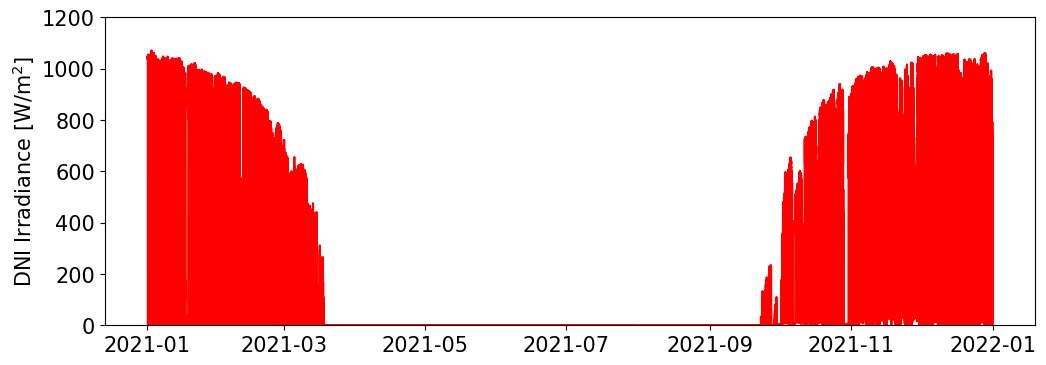

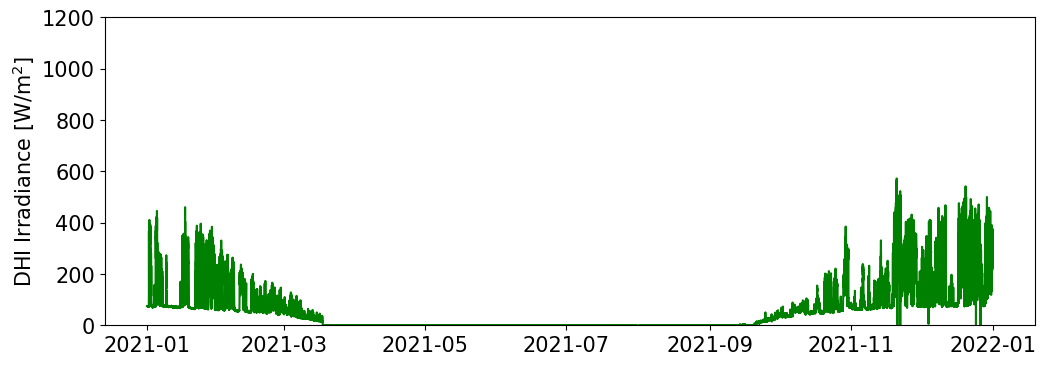

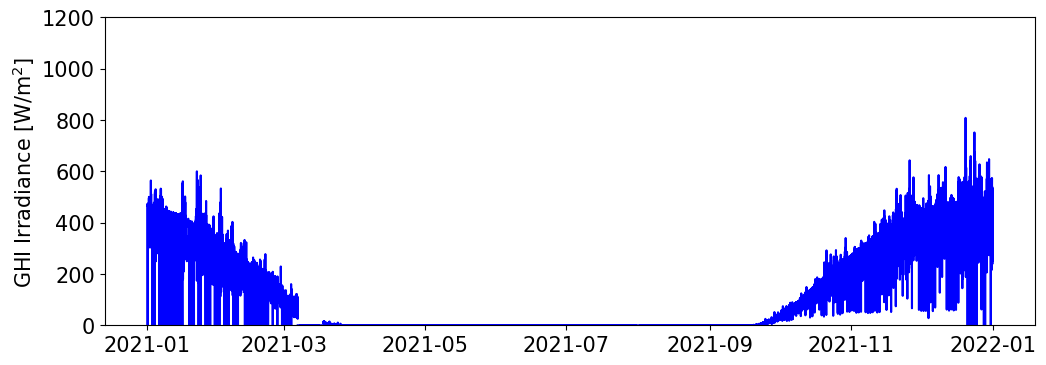

In [18]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(data['dni'], 'r')
plt.ylabel('DNI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['dhi'], 'g')
plt.ylabel('DHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])
plt.figure()
plt.plot(data['ghi'], 'b')
plt.ylabel('GHI Irradiance [W/m$^2$]')
plt.ylim([0, 1200])


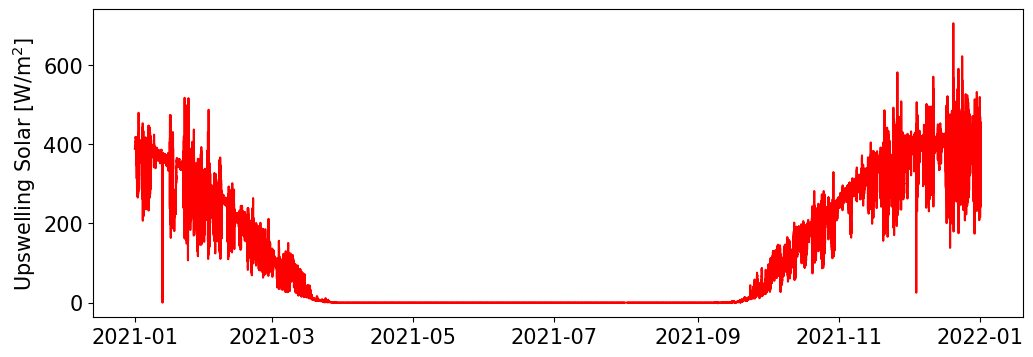

In [34]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(data['uw_solar'], 'r')
plt.ylabel('Upswelling Solar [W/m$^2$]');

(0.0, 1.2)

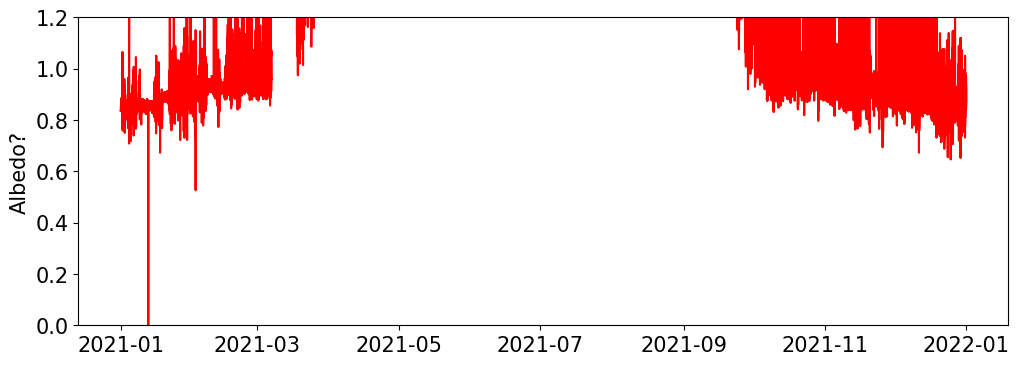

In [31]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(data['uw_solar']/data['ghi'], 'r')
plt.ylabel('Albedo?')
plt.ylim([0,1.2])